# ESE 4031 – Case Study 4  
## Denoising via Regularizers (Python)

This notebook implements the case study:

- We solve
  $$
  x^* = \operatorname{prox}_{\tau,h}(z)
  = \arg\min_{x \in \mathbb{R}^n} \frac{1}{2}\lVert x - z \rVert_2^2
    + \tau\,h(x)
  $$
  for different choices of the regularizer $h$ and parameter $\tau$.
- We start with a **Tikhonov** regularizer and use an **accelerated gradient method**.
- We evaluate performance using the **signal-to-noise ratio**
  $$
  \mathrm{SNR}(x^*) = 10 \log_{10}
  \frac{\lVert x \rVert_2^2}{\lVert x - x^* \rVert_2^2}.
  $$
- We then try other regularizers (including Lasso) and finally apply the method
  to a noisy 1-D barcode.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["font.size"] = 11

rng = np.random.default_rng(0)  # reproducible randomness


def snr(x_true, x_hat):
    """Signal-to-noise ratio in dB."""
    num = np.sum(x_true ** 2)
    den = np.sum((x_true - x_hat) ** 2)
    return 10 * np.log10(num / den)


def plot_signal(x, title="", xlabel="index", ylabel="value"):
    plt.plot(x, linewidth=1.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 1. Generating the clean signal and noisy observations

The handout suggests generating a random walk–type signal with

- $u_k \sim \text{Binomial}(1, 0.05) \cdot \mathcal{N}(0, 1)$,
- $x = \mathrm{cumsum}(u)$,

and then observing

$$
z = x + e, \quad e_k \sim \mathcal{N}(0, \sigma_k^2).
$$

For part (ii) we use:

- dimension $n = 512$,
- $\tau = 0.5$,
- $\sigma_k = 0.1$ for all $k$,
- 100 iterations of the algorithm.


SNR of noisy observation: 24.75969919220428


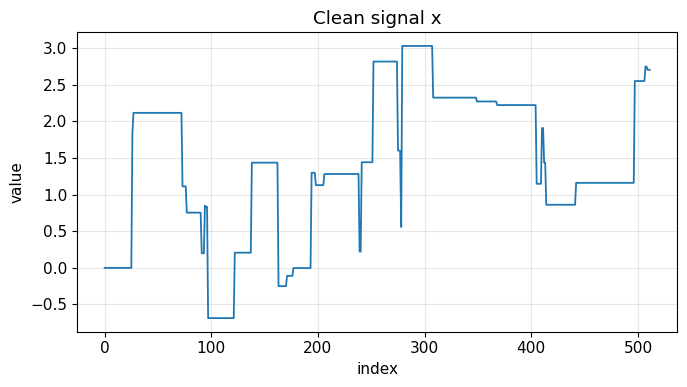

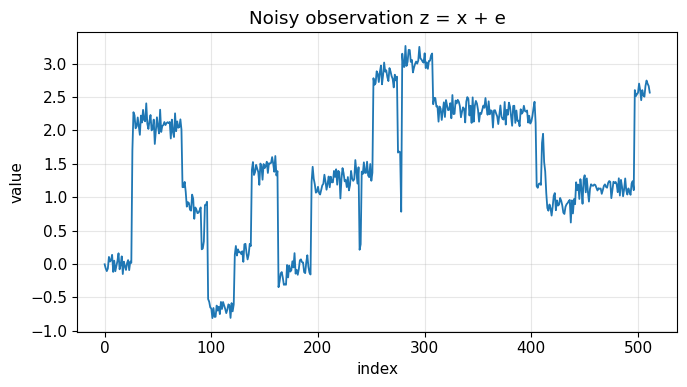

In [2]:
def generate_clean_signal(n, p_spike=0.05):
    """
    Random-walk-like signal:
    u_k ~ Bernoulli(p_spike) * Normal(0,1)
    x = cumulative sum of u.
    """
    u = rng.binomial(1, p_spike, size=n) * rng.standard_normal(size=n)
    x = np.cumsum(u)
    return x


def add_gaussian_noise(x, sigma=0.1):
    e = rng.normal(loc=0.0, scale=sigma, size=x.shape)
    return x + e


n = 512
sigma = 0.1

x_true = generate_clean_signal(n)
z = add_gaussian_noise(x_true, sigma)

print("SNR of noisy observation:", snr(x_true, z))

plot_signal(x_true, title="Clean signal x")
plot_signal(z, title="Noisy observation z = x + e")


## 2. Tikhonov regularizer and accelerated gradient method

We use a 1-D **Tikhonov regularizer** based on the discrete gradient:
$$
h_{\text{Tik}}(x) = \lVert D x \rVert_2^2,
$$
where $(Dx)_k = x_{k+1} - x_k$.

The objective is
$$
F(x) = \frac{1}{2}\lVert x - z \rVert_2^2 + \tau \lVert D x \rVert_2^2.
$$

This is smooth, with gradient
$$
\nabla F(x) = (x - z) + 2\tau D^\top Dx.
$$

For the 1-D first-difference operator, we can implement $D^\top D$ without
forming any large matrices, using simple differences.
We then apply an **accelerated gradient (FISTA)** method.


In [3]:
def grad_tikhonov(x, z, tau):
    """
    Gradient of F(x) = 0.5 * ||x - z||^2 + tau * ||Dx||^2,
    where (Dx)_k = x_{k+1} - x_k.
    """
    # data term
    grad_data = x - z

    # regularization term: g = 2 * D^T D x
    diff = x[1:] - x[:-1]  # length n-1
    g = np.zeros_like(x)
    g[0] = -diff[0]
    g[1:-1] = diff[:-1] - diff[1:]
    g[-1] = diff[-1]
    grad_reg = 2 * tau * g

    return grad_data + grad_reg


def tikhonov_fista(z, tau, n_iter=100):
    """
    Accelerated gradient (FISTA) for Tikhonov-regularized problem.
    """
    x = z.copy()
    y = x.copy()
    t = 1.0

    # Lipschitz constant L of grad F: approx 1 + 8 * tau for 1-D D^T D
    L = 1.0 + 8.0 * tau
    step = 1.0 / L

    for k in range(n_iter):
        grad = grad_tikhonov(y, z, tau)
        x_new = y - step * grad

        t_new = 0.5 * (1 + np.sqrt(1 + 4 * t * t))
        y = x_new + (t - 1) / t_new * (x_new - x)

        x, t = x_new, t_new

    return x


### 2.1 First runs for different parameter settings

For part (ii) we follow the handout and use

- dimension $n = 512$,
- noise level $\sigma_k = 0.1$ for all $k$,
- a base choice $\tau = 0.5$ and 100 iterations,

and then vary $\tau$ and the iteration count to see how the SNR changes.  
The baseline is the SNR of the noisy observation $z$.

In [4]:
taus = [0.1, 0.5, 1.0, 2.0]
n_iters_list = [50, 100, 200]

print("SNR of noisy observation (baseline):", snr(x_true, z))

for tau in taus:
    for n_iters in n_iters_list:
        x_hat = tikhonov_fista(z, tau, n_iter=n_iters)
        print(f"tau={tau:4.2f}, iters={n_iters:3d} -> SNR={snr(x_true, x_hat):5.2f} dB")


SNR of noisy observation (baseline): 24.75969919220428
tau=0.10, iters= 50 -> SNR=25.52 dB
tau=0.10, iters=100 -> SNR=25.52 dB
tau=0.10, iters=200 -> SNR=25.52 dB
tau=0.50, iters= 50 -> SNR=23.01 dB
tau=0.50, iters=100 -> SNR=23.01 dB
tau=0.50, iters=200 -> SNR=23.01 dB
tau=1.00, iters= 50 -> SNR=21.44 dB
tau=1.00, iters=100 -> SNR=21.44 dB
tau=1.00, iters=200 -> SNR=21.44 dB
tau=2.00, iters= 50 -> SNR=19.96 dB
tau=2.00, iters=100 -> SNR=19.96 dB
tau=2.00, iters=200 -> SNR=19.96 dB


SNR noisy   : 24.75969919220428
SNR denoised: 23.013883804719004


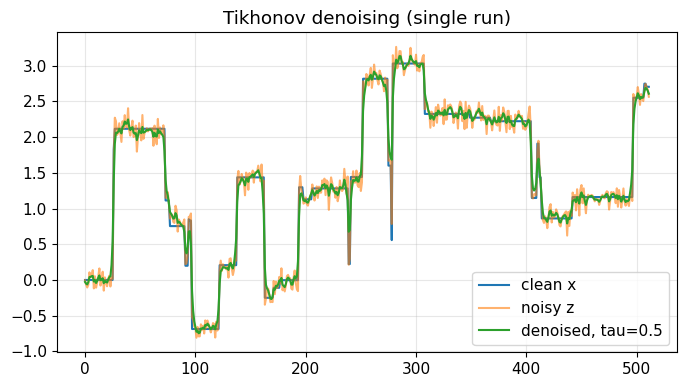

In [5]:
tau_demo = 0.5
iters_demo = 100

x_hat_demo = tikhonov_fista(z, tau_demo, n_iter=iters_demo)

print("SNR noisy   :", snr(x_true, z))
print("SNR denoised:", snr(x_true, x_hat_demo))

plt.plot(x_true, label="clean x", linewidth=1.5)
plt.plot(z, label="noisy z", alpha=0.6)
plt.plot(x_hat_demo, label=f"denoised, tau={tau_demo}", linewidth=1.5)
plt.legend()
plt.title("Tikhonov denoising (single run)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Approximating the optimal parameter $\tau^*$

We now fix $n = 512$, $\sigma = 0.1$, and a sufficiently large number
of iterations (e.g.\ 200), and search over a grid of $\tau$ values.

For each $\tau$ we compute $x^*(\tau)$ and its SNR. The $\tau$ that
maximizes SNR is our numerical approximation of $\tau^*$.


Best tau ≈ 0.050, SNR ≈ 25.55 dB


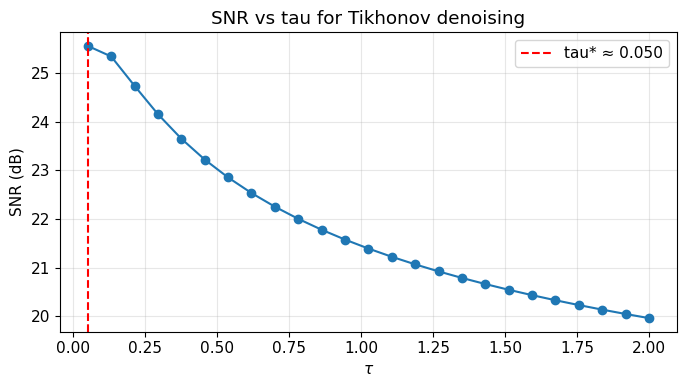

In [6]:
tau_grid = np.linspace(0.05, 2.0, 25)
snr_values = []

for tau in tau_grid:
    x_hat = tikhonov_fista(z, tau, n_iter=200)
    snr_values.append(snr(x_true, x_hat))

snr_values = np.array(snr_values)
best_idx = np.argmax(snr_values)
tau_star = tau_grid[best_idx]
best_snr = snr_values[best_idx]

print(f"Best tau ≈ {tau_star:.3f}, SNR ≈ {best_snr:.2f} dB")

plt.plot(tau_grid, snr_values, marker="o")
plt.axvline(tau_star, color="r", linestyle="--",
            label=f"tau* ≈ {tau_star:.3f}")
plt.xlabel(r"$\tau$")
plt.ylabel("SNR (dB)")
plt.title("SNR vs tau for Tikhonov denoising")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 3.1 Denoised signal at $\tau^*$

Here we plot the denoised signal corresponding to $\tau^*$ and report its SNR.
This can be compared to both the noisy signal and to earlier choices of $\tau$.

SNR at tau*=0.050: 25.55 dB
SNR of noisy observation:   24.76  dB


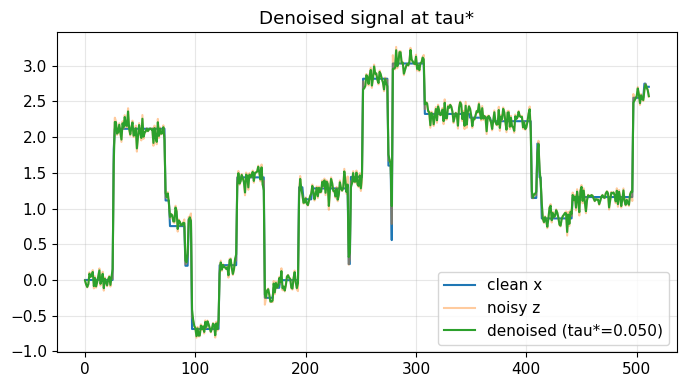

In [11]:
x_hat_star = tikhonov_fista(z, tau_star, n_iter=200)
print(f"SNR at tau*={tau_star:.3f}: {snr(x_true, x_hat_star):.2f} dB")
print(f"SNR of noisy observation:   {snr(x_true, z):.2f}  dB")

plt.plot(x_true, label="clean x", linewidth=1.5)
plt.plot(z, label="noisy z", alpha=0.4)
plt.plot(x_hat_star, label=f"denoised (tau*={tau_star:.3f})", linewidth=1.5)
plt.legend()
plt.title("Denoised signal at tau*")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Changing the regularizer $h$

So far we have used the Tikhonov regularizer
$$
h_{\mathrm{Tik}}(x) = \lVert D x \rVert_2^2.
$$

We now change $h$ and compare performance.  
A natural alternative is the **Lasso** (entrywise $\ell_1$) regularizer:
$$
h_{\mathrm{L1}}(x) = \lVert x \rVert_1.
$$

The objective becomes
$$
F(x) = \frac{1}{2}\lVert x - z \rVert_2^2 + \tau \lVert x \rVert_1.
$$

This function is not differentiable everywhere, but it is easily handled with a
**proximal gradient** method, where

- the smooth part is $f(x) = \tfrac{1}{2}\lVert x - z \rVert_2^2$ with gradient
  $\nabla f(x) = x - z$,
- the non-smooth part is $g(x) = \tau \lVert x \rVert_1$, whose proximal
  operator is the soft–thresholding operator.

In [7]:
def soft_threshold(v, lam):
    """Soft-thresholding operator: S_lam(v)."""
    return np.sign(v) * np.maximum(np.abs(v) - lam, 0.0)


def lasso_fista(z, tau, n_iter=100):
    """
    Proximal gradient with acceleration (FISTA) for
    0.5||x - z||^2 + tau ||x||_1.
    """
    x = z.copy()
    y = x.copy()
    t = 1.0

    L = 1.0  # Lipschitz constant of grad(0.5||x-z||^2) is 1
    step = 1.0 / L

    for k in range(n_iter):
        grad = y - z  # gradient of 0.5||x-z||^2 at y
        v = y - step * grad
        x_new = soft_threshold(v, tau * step)

        t_new = 0.5 * (1 + np.sqrt(1 + 4 * t * t))
        y = x_new + (t - 1) / t_new * (x_new - x)

        x, t = x_new, t_new

    return x


SNR noisy   : 24.75969919220428
SNR Tik (tau=0.050): 25.554509872099523
SNR L1  (tau=0.015): 24.78752138263048


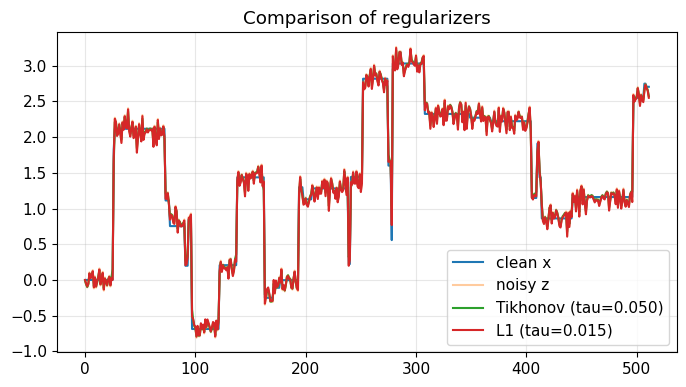

In [8]:
tau_tik = tau_star       # from earlier grid search
tau_l1 = tau_star * 0.3  # often need smaller tau for L1; adjust as needed

x_tik = tikhonov_fista(z, tau_tik, n_iter=200)
x_l1 = lasso_fista(z, tau_l1, n_iter=200)

print("SNR noisy   :", snr(x_true, z))
print(f"SNR Tik (tau={tau_tik:.3f}):", snr(x_true, x_tik))
print(f"SNR L1  (tau={tau_l1:.3f}):", snr(x_true, x_l1))

plt.plot(x_true, label="clean x", linewidth=1.5)
plt.plot(z, label="noisy z", alpha=0.4)
plt.plot(x_tik, label=f"Tikhonov (tau={tau_tik:.3f})", linewidth=1.5)
plt.plot(x_l1, label=f"L1 (tau={tau_l1:.3f})", linewidth=1.5)
plt.legend()
plt.title("Comparison of regularizers")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Barcode denoising

We now consider a one–dimensional barcode: a sequence of black/white
blocks of length $n = 512$.

Steps:

1. Generate a random binary barcode with contiguous blocks.
2. Add Gaussian noise to obtain $z$.
3. Denoise using a regularizer (here we use the Tikhonov regularizer,
   but we could also try L1).
4. Vary $\tau$ and compare the denoised barcodes to the original barcode.

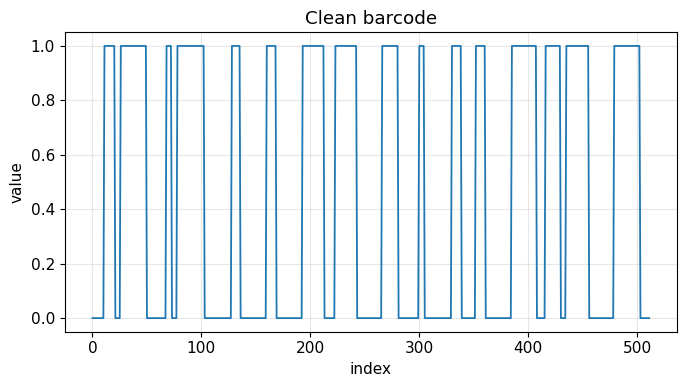

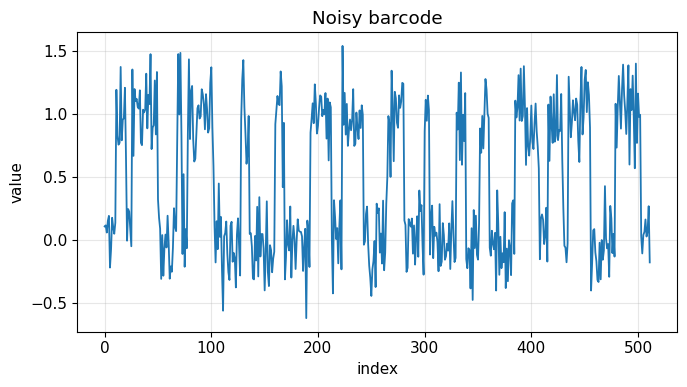

Barcode noisy SNR: 10.327331642575983


In [9]:
def generate_barcode(n, min_block=5, max_block=25):
    """
    Generate a 1D barcode of length n with random block lengths.
    Values are 0 or 1.
    """
    barcode = []
    value = 0
    while len(barcode) < n:
        block_len = rng.integers(min_block, max_block + 1)
        barcode.extend([value] * block_len)
        value = 1 - value  # flip between 0 and 1
    barcode = np.array(barcode[:n], dtype=float)
    return barcode


n_bar = 512
sigma_bar = 0.2

barcode_clean = generate_barcode(n_bar)
barcode_noisy = add_gaussian_noise(barcode_clean, sigma_bar)

plot_signal(barcode_clean, title="Clean barcode")
plot_signal(barcode_noisy, title="Noisy barcode")
print("Barcode noisy SNR:", snr(barcode_clean, barcode_noisy))


tau=0.10 -> SNR=12.48 dB
tau=0.30 -> SNR=13.34 dB
tau=0.70 -> SNR=12.92 dB
tau=1.50 -> SNR=11.79 dB


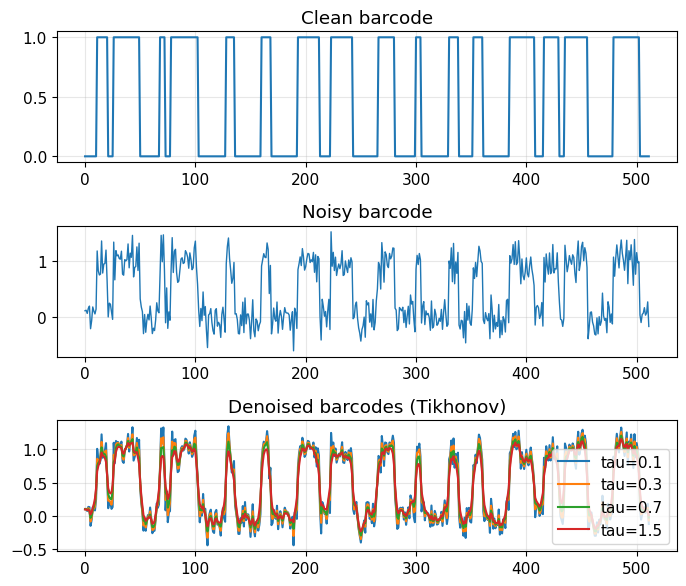

In [10]:
taus_bar = [0.1, 0.3, 0.7, 1.5]
denoised_barcodes = []

for tau in taus_bar:
    x_hat_bar = tikhonov_fista(barcode_noisy, tau, n_iter=200)
    denoised_barcodes.append(x_hat_bar)
    print(f"tau={tau:4.2f} -> SNR={snr(barcode_clean, x_hat_bar):5.2f} dB")

# Plot
plt.figure(figsize=(7, 6))
plt.subplot(3, 1, 1)
plt.plot(barcode_clean, linewidth=1.5)
plt.title("Clean barcode")
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(barcode_noisy, linewidth=1.0)
plt.title("Noisy barcode")
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
for tau, x_hat_bar in zip(taus_bar, denoised_barcodes):
    plt.plot(x_hat_bar, label=f"tau={tau}")
plt.title("Denoised barcodes (Tikhonov)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The SNR results and plots suggest that moderate values of $\tau$ (around 0.3–0.7)
give the best trade-off between noise removal and preservation of sharp barcode
edges; very small $\tau$ leaves too much noise, while very large $\tau$ oversmooths
the transitions.

## 6. Discussion

Points to discuss in the written report:

- How the SNR of the Tikhonov denoiser changes with $\tau$ and why there is
  an optimal range (too little vs too much smoothing).
- Comparison between Tikhonov and L1:
  - Which one gives higher SNR?
  - Which one preserves sharp transitions vs smooth regions better?
- For the barcode:
  - How visual quality changes with $\tau$.
  - Whether the chosen regularizer is well suited for piecewise–constant
    signals like barcodes.
- Any computational observations from the accelerated gradient method
  (e.g.\ convergence speed vs number of iterations).